# Model Training
--- 

## Zillow CA Rent Model
---

In [1]:
import logging

# Create a logger
logger = logging.getLogger(__name__)

# Set the logging level
logger.setLevel(logging.INFO)

# Create a file handler which logs even debug messages
file_handler = logging.FileHandler('training.log')
file_handler.setLevel(logging.INFO)

# Create a formatter and set the formatter for the file handler
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add the handlers to the logger
logger.addHandler(file_handler)

# Log a message to ensure the logger is working
logger.info('Training logger initialized')


### Load Training Data
---

In [2]:
import pandas as pd

TRAINING_DATA_ROOT_DIR='../data/training_data/'
ca_rent_training_set_1 = pd.read_feather(f'{TRAINING_DATA_ROOT_DIR}ca_rent_training_data_1.ft')

## Model Training
---

In [3]:

from sklearn.linear_model import LinearRegression

def train_linear_regression(X_train, y_train):
    """
    Trains a linear regression model on the given training data.

    Parameters:
    X_train (DataFrame): Training features.
    y_train (Series): Training target.

    Returns:
    LinearRegression: The trained linear regression model.
    """
    # Initialize the linear regression model
    model = LinearRegression()
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Log the model training completion
    logger.info('Linear regression model training completed')
    
    # Return the trained model
    return model


In [4]:
from sklearn.model_selection import GridSearchCV

def find_optimal_parameters(X, y, model):
    """
    Finds the optimal parameters for a given linear regression model using GridSearchCV.

    Parameters:
    X (DataFrame): Features.
    y (Series): Target.
    model (LinearRegression): The linear regression model instance.

    Returns:
    dict: A dictionary containing the optimal parameters.
    """
    # Define the parameters to search
    param_grid = {
        'fit_intercept': [True, False],
        'normalize': [True, False],
        'copy_X': [True, False]
    }
    
    # Initialize the GridSearchCV with the model and parameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    
    # Fit the GridSearchCV to the data
    grid_search.fit(X, y)
    
    # Return the optimal parameters
    return grid_search.best_params_

In [5]:
import pandas as pd
def print_model_metrics(model, x_test, y_test):
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
    
    logger.info('Starting model metrics calculation')
    
    # Make predictions on the test set
    logger.info('Making predictions on the test set')
    y_pred = model.predict(x_test)
    
    # Calculate the metrics on encoded data
    logger.info('Calculating metrics on encoded data')
    try:
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        evs = explained_variance_score(y_test, y_pred)
    except Exception as e:
        logger.error(f'Error calculating model metrics: {e}')
        return
    
    # Print the metrics
    logger.info('Printing model metrics')
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Explained Variance Score: {evs}")
    
    logger.info('Model metrics calculation completed')

# Example usage
# X = training_set1.drop(columns=['rent'])
# y = training_set1['rent']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from sklearn.ensemble import VotingRegressor

def create_ensembled_model(models, X_train, y_train):
    """
    Creates an ensembled model from a given set of models using VotingRegressor.

    Parameters:
    models (list): List of tuples where each tuple contains a model name and the model instance.
    X_train (DataFrame): Training features.
    y_train (Series): Training target.

    Returns:
    VotingRegressor: An ensembled model.
    """
    ensembled_model = VotingRegressor(estimators=models)
    ensembled_model.fit(X_train, y_train)
    return ensembled_model

# Example usage:
# models = [('model1', model1), ('model2', model2)]
# ensembled_model = create_ensembled_model(models, X_train, y_train)

#print_model_metrics(ensembled_model, X_test, y_test)

#### Model 1
----


## Preparing training data for model training
---
- encode all categorical data
- normalize data


In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def preprocess_data(df):
    """
    Encodes all categorical data and normalizes the data.

    Parameters:
    df (DataFrame): DataFrame to preprocess.

    Returns:
    DataFrame: Preprocessed DataFrame.
    """
    # Initialize encoder and scaler
    encoder = OneHotEncoder(sparse=False)
    scaler = StandardScaler()

    # Fit and transform categorical data
    encoded_data = encoder.fit_transform(df.select_dtypes(include=['object']))

    # Drop original categorical columns
    df = df.drop(columns=df.select_dtypes(include=['object']).columns)

    # Add encoded data to the DataFrame
    df = df.join(pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out()))

    # Scale numerical data
    scaled_data = scaler.fit_transform(df.select_dtypes(include=['int64', 'float64']))

    # Replace original numerical columns with scaled data
    df = pd.DataFrame(scaled_data, columns=df.select_dtypes(include=['int64', 'float64']).columns)

    return df

In [8]:
prpped_ca_rent_training_data_1 = preprocess_data(ca_rent_training_set_1)

/Users/oscarlopez/Desktop/portfolio/Zillow_Housing_Predictor/env/zillow_project/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Training first Linear Regression Model
---
- test size = 0.2
- random state = 42

In [9]:
from sklearn.model_selection import train_test_split

X = prpped_ca_rent_training_data_1.drop('rent', axis=1)
y = prpped_ca_rent_training_data_1['rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
lr_ca_rent_model_1 = train_linear_regression(X_train, y_train)

# Print model statistics
print_model_metrics(lr_ca_rent_model_1, X_test, y_test)



Mean Squared Error: 0.3072537855692576
Mean Absolute Error: 0.42635675374001986
R^2 Score: 0.7017359294077312
Explained Variance Score: 0.7036508248414703


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
lr_ca_rent_model_2 = train_linear_regression(X_train,y_train)

print_model_metrics(lr_ca_rent_model_2, X_test,y_test)

Mean Squared Error: 0.2878823467434421
Mean Absolute Error: 0.4158968947553501
R^2 Score: 0.712080338241182
Explained Variance Score: 0.7125725543910766


In [11]:
lr_models = [('Linear Regression CA Rent Model 1', lr_ca_rent_model_1),('Linear Regression CA Rent Model 2', lr_ca_rent_model_2)]
ens_lr_ca_rent_model = create_ensembled_model(lr_models,X_train,y_train)

In [12]:
print_model_metrics(ens_lr_ca_rent_model,X_test,y_test)

Mean Squared Error: 0.2878823467434421
Mean Absolute Error: 0.4158968947553501
R^2 Score: 0.712080338241182
Explained Variance Score: 0.7125725543910766


In [13]:
import matplotlib.pyplot as plt
def display_model_metrics_as_bar(model, X_test, y_test):
    """
    Displays the metrics of a model as a bar graph, including MSE, R2, and MAE.
    
    Parameters:
    - model: The model to evaluate.
    - X_test: The test features.
    - y_test: The test target.
    """
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Plotting
    plt.figure(figsize=(12, 5))  # Adjusted figure size to accommodate three metrics
    plt.bar(['MSE', 'R2', 'MAE'], [mse, r2, mae])
    plt.xlabel('Metric')
    plt.ylabel('Value')
    plt.title(f'Model Metrics: MSE={mse:.2f}, R2={r2:.2f}, MAE={mae:.2f}')
    plt.grid(True)
    plt.show()

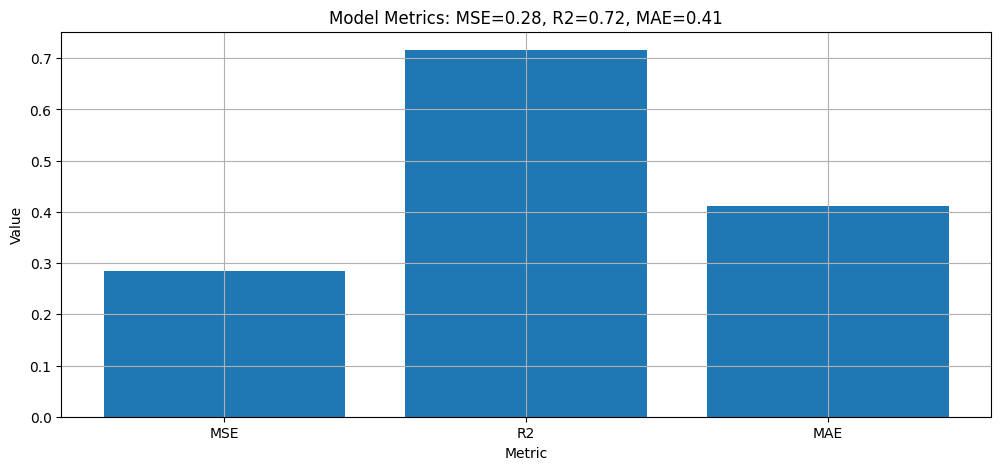

In [14]:
display_model_metrics_as_bar(lr_ca_rent_model_1,X_test,y_test)

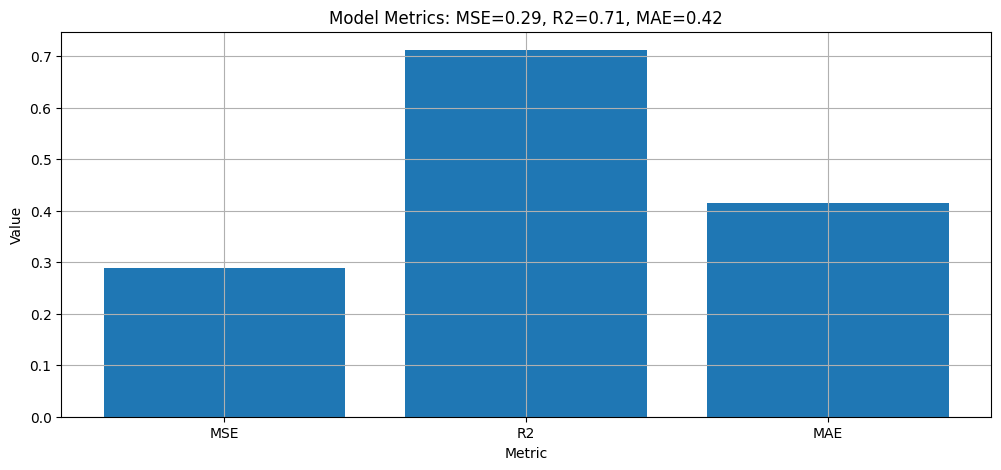

In [15]:
display_model_metrics_as_bar(lr_ca_rent_model_2,X_test,y_test)

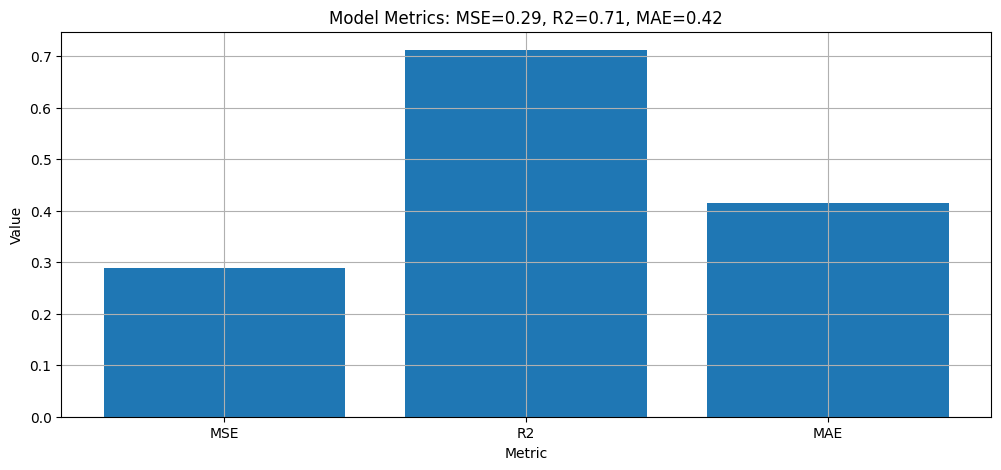

In [16]:
display_model_metrics_as_bar(ens_lr_ca_rent_model,X_test,y_test)

The MSE error is the same in the second model as it is ensembled, no performance gain.
Looking at these models we can tell we need better features and more training data.

 ---
 However regardless of performace I will use these models to test in later enmsembles and analyze performance then.

In [17]:
import os
import json

# Define the models to save
models_to_save = [lr_ca_rent_model_1, lr_ca_rent_model_2, ens_lr_ca_rent_model]
model_names = ['lr_ca_rent_model_1', 'lr_ca_rent_model_2', 'ens_lr_ca_rent_model']

# Define the directory to save the models
base_dir = '/Users/oscarlopez/Desktop/portfolio/Zillow_Housing_Predictor/Models'

# Loop through each model and save it along with its metrics
for model, model_name in zip(models_to_save, model_names):
    # Create a directory for the model if it doesn't exist
    model_dir = os.path.join(base_dir, model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Save the model using pickle
    model_path = os.path.join(model_dir, f'{model_name}.pkl')
    with open(model_path, 'wb') as f:
        import pickle
        pickle.dump(model, f)
    
    # Calculate and save the metrics
    metrics = print_model_metrics(model, X_test, y_test)
    metrics_path = os.path.join(model_dir, f'{model_name}_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)


Mean Squared Error: 0.2838825637701443
Mean Absolute Error: 0.4107744309654374
R^2 Score: 0.7160806396622583
Explained Variance Score: 0.716506183087116
Mean Squared Error: 0.2878823467434421
Mean Absolute Error: 0.4158968947553501
R^2 Score: 0.712080338241182
Explained Variance Score: 0.7125725543910766
Mean Squared Error: 0.2878823467434421
Mean Absolute Error: 0.4158968947553501
R^2 Score: 0.712080338241182
Explained Variance Score: 0.7125725543910766
